In [249]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt

In [345]:
results_clean = pd.read_csv("match_results/results_clean.csv", parse_dates=["date"])
team_universe = pd.read_csv("reference_data/team_universe.csv", header=None)[0].to_list()

def get_results(team, results=results_clean):
    return results.query(f"home_team == '{team}' or away_team == '{team}'")

In [346]:
import math
from dataclasses import dataclass
from typing import Dict, List, Optional, Tuple

import numpy as np
import pandas as pd


class Model:
    def __init__(self):
        self._is_fit = False

    def fit(self, results):
        pass

    def score(self):
        if not self._is_fit:
            raise Exception("Cannot score un-fit model")


@dataclass
class TeamState:
    """Gaussian belief over (attack, defence), tracked at last_update time."""
    m: np.ndarray              # shape (2,) -> [a, d]
    var: np.ndarray            # shape (2,) -> diagonal variances [var_a, var_d]
    last_update: pd.Timestamp


class FastDynamicBivarPoissonAD(Model):
    """
    Fast online attack/defence model for international football with:
      - continuous-time forgetting via variance growth: Var <- Var + q * Δt
      - bivariate Poisson scoreline model with shared intensity:
            nu = rho * min(mH, mA)
        (so mismatches do not create an unrealistic goals "floor")
      - per-match MAP update using analytic gradient + Gauss-Newton Hessian approx
        (no finite-diff Hessians; no SciPy).

    Outputs:
      - self.results_: copy of input df with prediction + loss columns
      - self.params_history_: long-form history of per-team parameters at each match date
    """

    def __init__(
        self,
        # Score model hyperparams (dimensionless on log intensity scale)
        mu: float = math.log(1.25),       # baseline log goals per team
        home_adv: float = 0.12,           # added if not neutral
        rho: float = 0.15,                # correlation scale in [0,1)
        # Time forgetting hyperparams (variance per day; same for attack & defence)
        drift_var_per_day: float = 2e-4,
        # Initial prior variance for unseen teams (diag, same for a and d)
        init_var: float = 0.5,
        # Prediction truncation for W/D/L probs from score matrix
        max_goals: int = 10,
        # Numerical / optimisation knobs
        eps: float = 1e-15,
        map_steps: int = 3,               # typically 2–4 is enough
        hess_damping: float = 1e-6,       # stabilises 4x4 solve
    ):
        super().__init__()
        if not (0.0 <= rho < 1.0):
            raise ValueError("rho must be in [0, 1).")
        if drift_var_per_day < 0:
            raise ValueError("drift_var_per_day must be >= 0.")
        if init_var <= 0:
            raise ValueError("init_var must be > 0.")
        if max_goals < 0:
            raise ValueError("max_goals must be >= 0.")

        self.mu = float(mu)
        self.home_adv = float(home_adv)
        self.rho = float(rho)
        self.drift_var_per_day = float(drift_var_per_day)
        self.init_var = float(init_var)
        self.max_goals = int(max_goals)
        self.eps = float(eps)
        self.map_steps = int(map_steps)
        self.hess_damping = float(hess_damping)

        # Fit artifacts required by user
        self.results_: Optional[pd.DataFrame] = None
        self.params_history_: Optional[pd.DataFrame] = None

        # Internal state
        self._teams: Dict[str, TeamState] = {}

    # -------------------------
    # Utilities
    # -------------------------

    @staticmethod
    def _outcome_from_score(hg: int, ag: int) -> str:
        if hg > ag:
            return "H"
        if hg < ag:
            return "A"
        return "D"

    def _get_or_init_team(self, team: str, t: pd.Timestamp) -> TeamState:
        st = self._teams.get(team)
        if st is not None:
            return st
        st = TeamState(
            m=np.array([0.0, 0.0], dtype=float),
            var=np.array([self.init_var, self.init_var], dtype=float),
            last_update=t,
        )
        self._teams[team] = st
        return st

    def _propagate_to_time(self, st: TeamState, t: pd.Timestamp) -> None:
        dt_days = float(max((t - st.last_update) / np.timedelta64(1, "D"), 0.0))
        if dt_days > 0.0 and self.drift_var_per_day > 0.0:
            st.var = st.var + self.drift_var_per_day * dt_days
            st.last_update = t
        else:
            st.last_update = t

    # -------------------------
    # Score model
    # -------------------------

    def _means_from_z(self, z: np.ndarray, neutral: bool) -> Tuple[float, float]:
        # z = [a_h, d_h, a_a, d_a]
        a_h, d_h, a_a, d_a = map(float, z)
        h = 0.0 if neutral else self.home_adv
        mH = math.exp(self.mu + h + a_h - d_a)
        mA = math.exp(self.mu + a_a - d_h)
        return mH, mA

    def _nu_lams(self, mH: float, mA: float) -> Tuple[float, float, float, bool]:
        """
        nu = rho * min(mH, mA)
        lam_h = mH - nu
        lam_a = mA - nu
        Returns (nu, lam_h, lam_a, home_is_min)
        """
        if mH <= mA:
            nu = self.rho * mH
            lam_h = mH - nu           # (1-rho)*mH
            lam_a = mA - nu
            return nu, lam_h, lam_a, True
        else:
            nu = self.rho * mA
            lam_h = mH - nu
            lam_a = mA - nu           # (1-rho)*mA
            return nu, lam_h, lam_a, False

    @staticmethod
    def _poisson_pmf_up_to(lam: float, G: int) -> np.ndarray:
        """Compute Poisson pmf for k=0..G stably via recursion."""
        pmf = np.zeros(G + 1, dtype=float)
        if lam < 0:
            return pmf
        pmf[0] = math.exp(-lam)
        if G == 0:
            return pmf
        for k in range(1, G + 1):
            pmf[k] = pmf[k - 1] * lam / k
        return pmf

    def _bivar_prob_matrix(self, lam_h: float, lam_a: float, nu: float, G: int) -> np.ndarray:
        """
        Fast construction of joint pmf matrix P[x,y] for x,y=0..G using:
          X = U + V, Y = U + W
          U~Pois(nu), V~Pois(lam_h), W~Pois(lam_a)
        """
        pu = self._poisson_pmf_up_to(nu, G)
        pv = self._poisson_pmf_up_to(lam_h, G)
        pw = self._poisson_pmf_up_to(lam_a, G)

        P = np.zeros((G + 1, G + 1), dtype=float)
        # For each k, add pu[k] * outer(pv[0:G-k], pw[0:G-k]) shifted by k
        for k in range(0, G + 1):
            if pu[k] == 0.0:
                continue
            vv = pv[: G + 1 - k]
            ww = pw[: G + 1 - k]
            P[k:, k:] += pu[k] * np.outer(vv, ww)
        return P

    def _score_logpmf(self, x: int, y: int, lam_h: float, lam_a: float, nu: float) -> float:
        """
        Exact log pmf for a single (x,y) using the defining sum over k.
        Used only for out-of-truncation exact-score probability, and for MAP update.
        """
        if lam_h < 0 or lam_a < 0 or nu < 0:
            return -np.inf

        kmax = min(x, y)

        # If nu==0, only k=0 contributes
        if nu == 0.0:
            # independent Poisson with means lam_h, lam_a
            return (
                -(lam_h + lam_a)
                + (x * math.log(lam_h) if x > 0 else 0.0)
                + (y * math.log(lam_a) if y > 0 else 0.0)
                - math.lgamma(x + 1.0)
                - math.lgamma(y + 1.0)
            )

        # Compute log terms for k=0..kmax
        log_terms = np.empty(kmax + 1, dtype=float)
        log_lh = -np.inf if lam_h == 0.0 else math.log(lam_h)
        log_la = -np.inf if lam_a == 0.0 else math.log(lam_a)
        log_nu = math.log(nu)

        for k in range(kmax + 1):
            # (lam_h^(x-k)/(x-k)!) (lam_a^(y-k)/(y-k)!) (nu^k/k!)
            if x - k < 0 or y - k < 0:
                log_terms[k] = -np.inf
                continue

            lt = 0.0
            if x - k > 0:
                if lam_h == 0.0:
                    log_terms[k] = -np.inf
                    continue
                lt += (x - k) * log_lh

            if y - k > 0:
                if lam_a == 0.0:
                    log_terms[k] = -np.inf
                    continue
                lt += (y - k) * log_la

            if k > 0:
                lt += k * log_nu

            lt -= math.lgamma((x - k) + 1.0)
            lt -= math.lgamma((y - k) + 1.0)
            lt -= math.lgamma(k + 1.0)
            log_terms[k] = lt

        # logsumexp
        m = float(np.max(log_terms))
        if not np.isfinite(m):
            return -np.inf
        lse = m + float(np.log(np.sum(np.exp(log_terms - m))))
        return -(lam_h + lam_a + nu) + lse

    def _expected_k(self, x: int, y: int, lam_h: float, lam_a: float, nu: float) -> float:
        """
        Compute E[K | X=x, Y=y] where K=U in the bivariate Poisson decomposition.
        Uses posterior weights over k in the defining sum.
        """
        kmax = min(x, y)
        if kmax == 0 or nu == 0.0:
            return 0.0

        log_lh = -np.inf if lam_h == 0.0 else math.log(lam_h)
        log_la = -np.inf if lam_a == 0.0 else math.log(lam_a)
        log_nu = math.log(nu)

        log_terms = np.empty(kmax + 1, dtype=float)
        for k in range(kmax + 1):
            if x - k < 0 or y - k < 0:
                log_terms[k] = -np.inf
                continue
            lt = 0.0
            if x - k > 0:
                if lam_h == 0.0:
                    log_terms[k] = -np.inf
                    continue
                lt += (x - k) * log_lh
            if y - k > 0:
                if lam_a == 0.0:
                    log_terms[k] = -np.inf
                    continue
                lt += (y - k) * log_la
            if k > 0:
                lt += k * log_nu
            lt -= math.lgamma((x - k) + 1.0)
            lt -= math.lgamma((y - k) + 1.0)
            lt -= math.lgamma(k + 1.0)
            log_terms[k] = lt

        m = float(np.max(log_terms))
        if not np.isfinite(m):
            return 0.0

        w = np.exp(log_terms - m)
        s = float(np.sum(w))
        if s <= 0.0:
            return 0.0
        w /= s
        ks = np.arange(kmax + 1, dtype=float)
        return float(np.sum(ks * w))

    # -------------------------
    # Fast MAP update (analytic grad + Gauss-Newton Hessian)
    # -------------------------

    def _map_update(
        self,
        prior_m: np.ndarray,     # shape (4,)
        prior_var: np.ndarray,   # shape (4,) diagonal variances
        x: int,
        y: int,
        neutral: bool,
    ) -> Tuple[np.ndarray, np.ndarray]:
        """
        Return (post_mean_z, post_var_z_diag) for z=[a_h,d_h,a_a,d_a].
        Uses a few damped Newton steps with:
          grad = prior_prec*(z-prior_m) - grad_loglik
          Hess ≈ prior_prec + sum_c w_c * (dlam_c/dz)(dlam_c/dz)^T  (Gauss-Newton)
        """
        z = prior_m.copy()
        prior_prec = 1.0 / np.maximum(prior_var, 1e-12)

        for _ in range(self.map_steps):
            mH, mA = self._means_from_z(z, neutral)
            nu, lam_h, lam_a, home_is_min = self._nu_lams(mH, mA)

            lam_h = max(lam_h, 1e-12)
            lam_a = max(lam_a, 1e-12)
            nu_eps = max(nu, 1e-12)

            # E[k | x,y]
            ek = self._expected_k(x, y, lam_h, lam_a, nu)
            ex = x - ek
            ey = y - ek

            # d loglik / d lam (not log-lam)
            dL_dlam_h = ex / lam_h - 1.0
            dL_dlam_a = ey / lam_a - 1.0
            dL_dnu = ek / nu_eps - 1.0

            # Derivatives of mH, mA wrt z
            # z = [a_h, d_h, a_a, d_a]
            dmH_dz = mH * np.array([1.0, 0.0, 0.0, -1.0], dtype=float)
            dmA_dz = mA * np.array([0.0, -1.0, 1.0, 0.0], dtype=float)

            # Derivatives of (nu, lam_h, lam_a) wrt mH,mA (piecewise by min)
            if home_is_min:
                # nu = rho*mH
                dnu_dmH, dnu_dmA = self.rho, 0.0
                dlh_dmH, dlh_dmA = 1.0 - self.rho, 0.0         # lam_h = (1-rho)*mH
                dla_dmH, dla_dmA = -self.rho, 1.0              # lam_a = mA - rho*mH
            else:
                # nu = rho*mA
                dnu_dmH, dnu_dmA = 0.0, self.rho
                dlh_dmH, dlh_dmA = 1.0, -self.rho              # lam_h = mH - rho*mA
                dla_dmH, dla_dmA = 0.0, 1.0 - self.rho         # lam_a = (1-rho)*mA

            # Chain to z
            dnu_dz = dnu_dmH * dmH_dz + dnu_dmA * dmA_dz
            dlh_dz = dlh_dmH * dmH_dz + dlh_dmA * dmA_dz
            dla_dz = dla_dmH * dmH_dz + dla_dmA * dmA_dz

            # log-likelihood gradient wrt z
            grad_loglik = dL_dlam_h * dlh_dz + dL_dlam_a * dla_dz + dL_dnu * dnu_dz

            # negative log posterior gradient: prior term - loglik term
            grad = prior_prec * (z - prior_m) - grad_loglik

            # Gauss-Newton weights for curvature in lam-space
            # For Poisson, -d2 log / d lam^2 ≈ count / lam^2
            w_lh = max(ex, 0.0) / (lam_h * lam_h)
            w_la = max(ey, 0.0) / (lam_a * lam_a)
            w_nu = max(ek, 0.0) / (nu_eps * nu_eps)

            H = np.diag(prior_prec)
            H += w_lh * np.outer(dlh_dz, dlh_dz)
            H += w_la * np.outer(dla_dz, dla_dz)
            H += w_nu * np.outer(dnu_dz, dnu_dz)

            # Damping for numerical stability
            H += self.hess_damping * np.eye(4)

            try:
                step = np.linalg.solve(H, grad)
            except np.linalg.LinAlgError:
                step = np.linalg.pinv(H) @ grad

            z_new = z - step

            # small stopping check
            if float(np.linalg.norm(z_new - z)) < 1e-6:
                z = z_new
                break
            z = z_new

        # Approx posterior covariance (diagonal) from inverse Hessian at final iterate
        mH, mA = self._means_from_z(z, neutral)
        nu, lam_h, lam_a, home_is_min = self._nu_lams(mH, mA)
        lam_h = max(lam_h, 1e-12)
        lam_a = max(lam_a, 1e-12)
        nu_eps = max(nu, 1e-12)

        ek = self._expected_k(x, y, lam_h, lam_a, nu)
        ex = x - ek
        ey = y - ek

        dmH_dz = mH * np.array([1.0, 0.0, 0.0, -1.0], dtype=float)
        dmA_dz = mA * np.array([0.0, -1.0, 1.0, 0.0], dtype=float)

        if home_is_min:
            dnu_dmH, dnu_dmA = self.rho, 0.0
            dlh_dmH, dlh_dmA = 1.0 - self.rho, 0.0
            dla_dmH, dla_dmA = -self.rho, 1.0
        else:
            dnu_dmH, dnu_dmA = 0.0, self.rho
            dlh_dmH, dlh_dmA = 1.0, -self.rho
            dla_dmH, dla_dmA = 0.0, 1.0 - self.rho

        dnu_dz = dnu_dmH * dmH_dz + dnu_dmA * dmA_dz
        dlh_dz = dlh_dmH * dmH_dz + dlh_dmA * dmA_dz
        dla_dz = dla_dmH * dmH_dz + dla_dmA * dmA_dz

        w_lh = max(ex, 0.0) / (lam_h * lam_h)
        w_la = max(ey, 0.0) / (lam_a * lam_a)
        w_nu = max(ek, 0.0) / (nu_eps * nu_eps)

        H = np.diag(prior_prec)
        H += w_lh * np.outer(dlh_dz, dlh_dz)
        H += w_la * np.outer(dla_dz, dla_dz)
        H += w_nu * np.outer(dnu_dz, dnu_dz)
        H += self.hess_damping * np.eye(4)

        try:
            cov = np.linalg.inv(H)
        except np.linalg.LinAlgError:
            cov = np.linalg.pinv(H)

        post_var = np.maximum(np.diag(cov), 1e-12)
        return z, post_var

    # -------------------------
    # Fit
    # -------------------------

    def fit(self, results: pd.DataFrame) -> None:
        if not isinstance(results, pd.DataFrame):
            raise TypeError("results must be a pandas DataFrame")

        df = results.copy()
        df = df.sort_values("date").reset_index(drop=True)

        # Required columns
        needed = {"date", "home_team", "away_team", "home_score", "away_score", "neutral"}
        missing = needed - set(df.columns)
        if missing:
            raise ValueError(f"results is missing required columns: {sorted(missing)}")

        # Add requested prediction/loss columns
        for col in [
            "pr_home_win", "pr_draw", "pr_away_win",
            "pr_outcome", "pr_score",
            "loss_outcome", "loss_score",
        ]:
            df[col] = np.nan

        params_rows: List[dict] = []

        G = self.max_goals
        eps = self.eps

        # Main loop
        for idx, row in df.iterrows():
            t = pd.Timestamp(row["date"])
            home = str(row["home_team"])
            away = str(row["away_team"])
            x = int(row["home_score"])
            y = int(row["away_score"])
            neutral = bool(row["neutral"])

            # init + propagate
            st_h = self._get_or_init_team(home, t)
            st_a = self._get_or_init_team(away, t)
            self._propagate_to_time(st_h, t)
            self._propagate_to_time(st_a, t)

            # Prior mean/var for z=[a_h,d_h,a_a,d_a]
            prior_m = np.array([st_h.m[0], st_h.m[1], st_a.m[0], st_a.m[1]], dtype=float)
            prior_var = np.array([st_h.var[0], st_h.var[1], st_a.var[0], st_a.var[1]], dtype=float)

            # Predict via fast matrix construction at prior mean
            mH, mA = self._means_from_z(prior_m, neutral)
            nu, lam_h, lam_a, _ = self._nu_lams(mH, mA)

            Pxy = self._bivar_prob_matrix(lam_h, lam_a, nu, G)

            # Outcome probabilities from truncated matrix
            pr_h = float(np.sum(Pxy[np.tril_indices(G + 1, k=-1)]))  # x > y
            pr_d = float(np.sum(np.diag(Pxy)))                       # x = y
            pr_a = float(np.sum(Pxy[np.triu_indices(G + 1, k=1)]))   # x < y

            s_out = pr_h + pr_d + pr_a
            if s_out > 0.0:
                pr_h /= s_out
                pr_d /= s_out
                pr_a /= s_out

            # Exact score probability
            if x <= G and y <= G:
                pr_score = float(Pxy[x, y])
                # Pxy is already a valid pmf over 0..G only up to truncation; but pr_score is fine as-is.
                pr_score = float(np.clip(pr_score, eps, 1.0))
            else:
                # Compute exact pmf for out-of-range scores
                lp = self._score_logpmf(x, y, lam_h, lam_a, nu)
                pr_score = float(np.clip(math.exp(lp) if np.isfinite(lp) else 0.0, eps, 1.0))

            # Outcome probability for realised outcome
            outcome = self._outcome_from_score(x, y)
            pr_out = pr_h if outcome == "H" else (pr_d if outcome == "D" else pr_a)
            pr_out = float(np.clip(pr_out, eps, 1.0))

            # Write predictions/losses
            df.at[idx, "pr_home_win"] = pr_h
            df.at[idx, "pr_draw"] = pr_d
            df.at[idx, "pr_away_win"] = pr_a
            df.at[idx, "pr_outcome"] = pr_out
            df.at[idx, "pr_score"] = pr_score
            df.at[idx, "loss_outcome"] = -math.log(pr_out) / math.log(1/3) # normalise so that the trivial uniform predictor achieves -1
            df.at[idx, "loss_score"] = -math.log(pr_score)

            # Fast MAP update
            post_m, post_var = self._map_update(prior_m, prior_var, x, y, neutral)

            # Write back (means and diagonal variances only)
            st_h.m = np.array([post_m[0], post_m[1]], dtype=float)
            st_a.m = np.array([post_m[2], post_m[3]], dtype=float)
            st_h.var = np.array([post_var[0], post_var[1]], dtype=float)
            st_a.var = np.array([post_var[2], post_var[3]], dtype=float)

            # Record parameter history (two rows per match)
            params_rows.append({
                "date": t, "team": home,
                "attack_mean": float(st_h.m[0]),
                "defence_mean": float(st_h.m[1]),
                "attack_var": float(st_h.var[0]),
                "defence_var": float(st_h.var[1]),
            })
            params_rows.append({
                "date": t, "team": away,
                "attack_mean": float(st_a.m[0]),
                "defence_mean": float(st_a.m[1]),
                "attack_var": float(st_a.var[0]),
                "defence_var": float(st_a.var[1]),
            })

        # Persist requested outputs
        self.results_ = df
        self.params_history_ = (
            pd.DataFrame(params_rows)
            .sort_values(["date", "team"])
            .reset_index(drop=True)
        )

        self._is_fit = True
        return None


In [347]:
model = FastDynamicBivarPoissonAD(
    mu=math.log(1.25),          # baseline goals per team
    home_adv=0.12,              # home advantage on log scale
    rho=0.15,                   # correlation strength
    drift_var_per_day=1e-5,     # time-based forgetting
    init_var=0.5,               # uncertainty for new teams
    max_goals=8,                # truncation for W/D/L probs
)
model.fit(results_clean)

In [343]:
P = model.params_history_.copy()
P["quality_mean"] = P["attack_mean"] + P["defence_mean"]
P.sort_values("quality_mean")

,date,team,attack_mean,defence_mean,attack_var,defence_var,quality_mean
59209,2007-06-17,Guam,-2.857054,-2.819157,0.153080,0.015751,-5.676212
59245,2007-06-21,Guam,-2.733989,-2.876084,0.133073,0.013315,-5.610073
57249,2006-04-06,Guam,-2.807261,-2.758424,0.148717,0.013434,-5.565685
57220,2006-04-01,Guam,-2.715416,-2.812749,0.148682,0.014471,-5.528164
57233,2006-04-03,Guam,-2.744325,-2.781159,0.148699,0.013921,-5.525484
...,...,...,...,...,...,...,...
2742,1930-03-30,Costa Rica,1.265453,0.727615,0.060063,0.163892,1.993068
788,1913-10-26,Denmark,1.262160,0.799553,0.027830,0.177630,2.061713
2746,1930-04-04,Costa Rica,1.323924,0.824039,0.046449,0.163927,2.147963
2738,1930-03-26,Costa Rica,1.312763,0.838784,0.063031,0.225896,2.151547


<Axes: xlabel='date'>

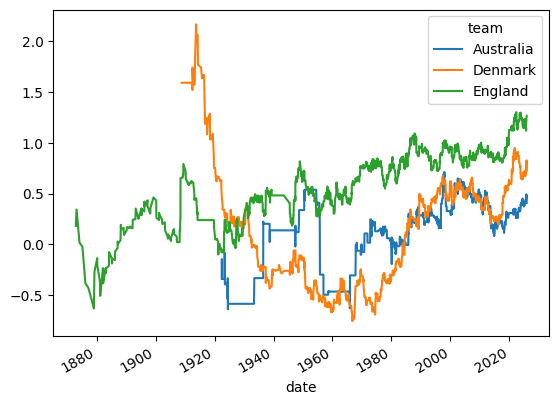

In [ ]:
pd.pivot_table(
    P.loc[P.team.isin(["Australia", "England", "Denmark"])],
    index="date",
    columns="team",
    values="quality_mean"
).ffill().plot()
# hello

In [348]:
get_results("Denmark", model.results_)

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,shootout_winner,shootout_first_shooter,pr_home_win,pr_draw,pr_away_win,pr_outcome,pr_score,loss_outcome,loss_score
229,1908-10-22,France,Denmark,1,17,Olympic Games,London,England,True,NaN,NaN,0.208443,0.249821,0.541736,0.541736,1.566847e-12,-0.557955,27.181956
340,1912-06-30,Denmark,Norway,7,0,Olympic Games,Stockholm,Sweden,True,NaN,NaN,0.999431,0.000468,0.000101,0.999431,1.247913e-02,-0.000518,4.383697
345,1912-07-02,Denmark,Netherlands,4,1,Olympic Games,Stockholm,Sweden,True,NaN,NaN,0.745685,0.122561,0.131754,0.745685,5.161284e-02,-0.267112,2.963985
357,1912-10-06,Denmark,Germany,3,1,Friendly,Copenhagen,Denmark,False,NaN,NaN,0.983900,0.011173,0.004927,0.983900,8.966771e-03,-0.014774,4.714230
382,1913-05-25,Denmark,Sweden,8,0,Friendly,Copenhagen,Denmark,False,NaN,NaN,0.953068,0.032253,0.014679,0.953068,2.917526e-02,-0.043755,3.534434
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45998,2025-09-08,Greece,Denmark,0,3,FIFA World Cup qualification,Athens,Greece,False,NaN,NaN,0.295979,0.338693,0.365328,0.365328,2.018581e-02,-0.916575,3.902775
46097,2025-10-09,Belarus,Denmark,0,6,FIFA World Cup qualification,Zalaegerszeg,Hungary,True,NaN,NaN,0.055258,0.152903,0.791838,0.791838,1.142686e-02,-0.212448,4.471788
46146,2025-10-12,Denmark,Greece,3,1,FIFA World Cup qualification,Copenhagen,Denmark,False,NaN,NaN,0.517940,0.290925,0.191135,0.517940,4.246757e-02,-0.598843,3.159015
46271,2025-11-15,Denmark,Belarus,2,2,FIFA World Cup qualification,Copenhagen,Denmark,False,NaN,NaN,0.870796,0.097073,0.032131,0.097073,1.543591e-02,-2.122939,4.171058


In [318]:
P.groupby("team").last().quality_mean.sort_values(ascending=False).head(20)

team
Argentina      1.523718
Spain          1.405445
Brazil         1.386969
England        1.264911
Colombia       1.187450
France         1.152529
Portugal       1.129057
Netherlands    0.991780
Germany        0.944041
Belgium        0.846829
Japan          0.816353
Uruguay        0.806927
Italy          0.733904
Denmark        0.726553
Morocco        0.702419
Ecuador        0.696144
Croatia        0.694582
Switzerland    0.685980
Norway         0.593155
USA            0.560037
Name: quality_mean, dtype: float64

In [177]:
results = pd.read_csv("match_results/results.csv", parse_dates=["date"])
renamer = {
    row.original_name: row.replacement_name
    for row in pd.read_csv("reference_data/kaggle_team_to_canonical_name_map.csv").itertuples()
}
results["home_team"] = results["home_team"].apply(lambda t: renamer.get(t, t))
results["away_team"] = results["away_team"].apply(lambda t: renamer.get(t, t))

In [221]:
r = results.merge(results_clean, on=["date", "home_team", "away_team"], how="left", suffixes=("", "_right")).query("home_score_right.isna()")

In [216]:
majors = [
    "FIFA World Cup",
    "Confederations Cup",
    "UEFA Euro",
    "Copa América",
    "African Cup of Nations",
    "AFC Asian Cup",
    "Gold Cup",
    "Oceania Nations Cup",
    "UEFA Nations League",
    "CONCACAF Nations League"
]
majors_plus_qual = [m.lower() for m in majors] + [m.lower() + " qualification" for m in majors]

In [228]:
worrying = r.loc[r.tournament.str.lower().isin(majors_plus_qual)]

In [241]:
T = sorted(set(worrying.home_team.to_list() + worrying.away_team.to_list()))
for t in [t for t in T if t not in team_universe]: print(t)

Bonaire
French Guiana
Guadeloupe
Martinique
Saint Martin
Sint Maarten


In [210]:
r.query("~home_score_right.isna()").tournament.value_counts().loc[majors]

tournament
FIFA World Cup             964
Confederations Cup         140
UEFA Euro                  388
Copa América               869
African Cup of Nations     793
AFC Asian Cup              421
Gold Cup                   373
Oceania Nations Cup        139
UEFA Nations League        658
CONCACAF Nations League    308
Name: count, dtype: int64

In [211]:
r.query("home_score_right.isna()").tournament.value_counts().loc[majors]

KeyError: "['FIFA World Cup', 'Confederations Cup', 'UEFA Euro', 'Copa América', 'African Cup of Nations', 'AFC Asian Cup', 'Oceania Nations Cup', 'UEFA Nations League'] not in index"

In [136]:
results_raw = pd.read_csv("match_results/results.csv", parse_dates=["date"])
# former_names = pd.read_csv("match_results/former_names.csv")
results_teams_raw = sorted(set(results_raw.home_team.to_list() + results_raw.away_team.to_list()))
results = results_raw.copy()
mapping = {row.original_name: row.replacement_name for row in pd.read_csv("reference_data/kaggle_team_to_canonical_name_map.csv").itertuples()}
results["home_team"] = results["home_team"].apply(lambda t: mapping.get(t, t))
results["away_team"] = results["away_team"].apply(lambda t: mapping.get(t, t))
results_teams = list(set([mapping.get(name, name) for name in results_teams_raw]))

def get_results(team, results=results):
    return results.query(f"home_team == '{team}' or away_team == '{team}'")

fifa_members_raw = pd.read_csv("reference_data/fifa_members_with_flag_sources.csv").country.to_list()
mapping = {row.original_name: row.replacement_name for row in pd.read_csv("reference_data/fifa_member_to_canonical_name_map.csv").itertuples()}
fifa_members_canonical = [mapping.get(name, name) for name in fifa_members_raw]

results["n_fifa_members"] = results.home_team.isin(fifa_members_canonical).astype(int) + results.away_team.isin(fifa_members_canonical).astype(int)

In [137]:
teams = pd.DataFrame(
    index=results_teams,
    columns=["both", "one", "neither"],
    dtype=bool
)
teams[:] = False

r = results.loc[results.tournament.str.lower().str.contains("fifa world cup")]#.loc[results.date >= dt.datetime(2000, 1, 1)]
teams.loc[r.query("n_fifa_members == 2").home_team.to_list()+r.query("n_fifa_members == 2").away_team.to_list(), "both"] = True
teams.loc[r.query("n_fifa_members == 1").home_team.to_list()+r.query("n_fifa_members == 1").away_team.to_list(), "one"] = True
teams.loc[r.query("n_fifa_members == 0").home_team.to_list()+r.query("n_fifa_members == 0").away_team.to_list(), "neither"] = True

teams["last_year_played_home"] = r.groupby("home_team").apply(lambda G: G.date.dt.year.max())
teams["last_year_played_away"] = r.groupby("away_team").apply(lambda G: G.date.dt.year.max())
teams["last_year_played_home"] = teams["last_year_played_home"].fillna(0)
teams["last_year_played_away"] = teams["last_year_played_away"].fillna(0)
teams["last_year_played"] = np.maximum(teams["last_year_played_home"], teams["last_year_played_away"]).astype(int)
teams.drop(columns=["last_year_played_home", "last_year_played_away"], inplace=True)

teams["n_matches"] = 0
h = r["home_team"].value_counts()
a = r["away_team"].value_counts()
for x in (h, a):
    teams.loc[x.index, "n_matches"] += x.values
teams["n_matches"] = teams["n_matches"].astype(int)

/var/folders/y9/7mrfwwc97kg93k2qmfccslvm0000gn/T/ipykernel_32100/2797592036.py:13: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  teams["last_year_played_home"] = r.groupby("home_team").apply(lambda G: G.date.dt.year.max())
/var/folders/y9/7mrfwwc97kg93k2qmfccslvm0000gn/T/ipykernel_32100/2797592036.py:14: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  teams["last_year_played_away"] = r.groupby("away_team").apply(lambda

In [138]:
teams.query("~both").n_matches.sort_values(ascending=False).head(20)

Czechoslovakia               101
Yugoslavia                    99
East Germany                  53
Saarland                       4
Saint Helena                   0
Manchukuo                      0
Madrid                         0
Saare County                   0
Republic of St. Pauli          0
Marshall Islands               0
United Koreans in Japan        0
Padania                        0
Elba Island                    0
Wallis Islands and Futuna      0
Délvidék                       0
Ellan Vannin                   0
West Papua                     0
Åland Islands                  0
County of Nice                 0
Northern Mariana Islands       0
Name: n_matches, dtype: int64

In [93]:
get_results("German DR", r)

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,n_fifa_members
4457,1957-05-19,German DR,Wales,2.0,1.0,FIFA World Cup qualification,Leipzig,German DR,False,1
4483,1957-06-16,Czechoslovakia,German DR,3.0,1.0,FIFA World Cup qualification,Brno,Czechoslovakia,False,0
4563,1957-09-25,Wales,German DR,4.0,1.0,FIFA World Cup qualification,Cardiff,Wales,False,1
4586,1957-10-27,German DR,Czechoslovakia,1.0,4.0,FIFA World Cup qualification,Leipzig,German DR,False,0
5247,1961-04-16,Hungary,German DR,2.0,0.0,FIFA World Cup qualification,Budapest,Hungary,False,1
5270,1961-05-14,German DR,Netherlands,1.0,1.0,FIFA World Cup qualification,Leipzig,German DR,False,1
5327,1961-09-10,German DR,Hungary,2.0,3.0,FIFA World Cup qualification,Berlin,German DR,False,1
6270,1965-04-25,Austria,German DR,1.0,1.0,FIFA World Cup qualification,Vienna,Austria,False,1
6307,1965-05-23,German DR,Hungary,1.0,1.0,FIFA World Cup qualification,Leipzig,German DR,False,1
6463,1965-10-09,Hungary,German DR,3.0,2.0,FIFA World Cup qualification,Budapest,Hungary,False,1


In [53]:
teams.query("last_year_played > 2000")[["both", "one", "neither"]].value_counts().sort_index()

both   one    neither
False  False  True        59
       True   False        4
              True        44
True   False  False      101
       True   False      110
Name: count, dtype: int64

In [56]:
r.query("home_team == 'Ynys Môn' or away_team == 'Ynys Môn'")

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,n_fifa_members
25749,2001-07-08,Ynys Môn,Saare County,4.0,1.0,Island Games,Castletown,Isle of Man,True,0
25758,2001-07-10,Ynys Môn,Shetland,1.0,1.0,Island Games,Douglas,Isle of Man,True,0
25771,2001-07-12,Ynys Môn,Jersey,2.0,2.0,Island Games,Castletown,Isle of Man,True,0
25780,2001-07-13,Guernsey,Ynys Môn,0.0,0.0,Island Games,Douglas,Isle of Man,True,0
27325,2003-06-29,Saare County,Ynys Môn,0.0,2.0,Island Games,Saint Sampson,Guernsey,True,0
27345,2003-07-01,Ynys Môn,Isle of Man,1.0,2.0,Island Games,Saint Sampson,Guernsey,True,0
27369,2003-07-04,Gibraltar,Ynys Môn,0.0,2.0,Island Games,Saint Sampson,Guernsey,True,1
29320,2005-07-10,Greenland,Ynys Môn,0.0,0.0,Island Games,Shetland,Scotland,True,0
29331,2005-07-12,Orkney,Ynys Môn,0.0,2.0,Island Games,Shetland,Scotland,True,0
29337,2005-07-13,Ynys Môn,Western Isles,0.0,0.0,Island Games,Shetland,Scotland,True,0


In [54]:
teams.query("last_year_played > 2000").query("both == False and one == True").sort_values("last_year_played", ascending=False)

,both,one,neither,last_year_played
Martinique,False,True,True,2025
Guadeloupe,False,True,True,2025
Zanzibar,False,True,True,2025
Bonaire,False,True,True,2025
Ynys Môn,False,True,True,2025
Western Isles,False,True,True,2025
Jersey,False,True,True,2025
Sint Maarten,False,True,True,2025
Shetland,False,True,True,2025
Marshall Islands,False,True,False,2025


In [91]:
for t in [t for t in results_teams if t not in fifa_members_canonical]: print(t)

Abkhazia
Alderney
Ambazonia
Andalusia
Arameans Suryoye
Artsakh
Asturias
Aymara
Barawa
Basque Country
Biafra
Bonaire
Brittany
Canary Islands
Cascadia
Catalonia
Central Spain
Chagos Islands
Chameria
Chechnya
Cilento
Corsica
County of Nice
Crimea
Czechoslovakia
Darfur
Donetsk PR
Délvidék
Elba Island
Ellan Vannin
Falkland Islands
Felvidék
Franconia
French Guiana
Frøya
Galicia
German DR
Gotland
Gozo
Greenland
Guadeloupe
Guernsey
Găgăuzia
Hitra
Hmong
Iraqi Kurdistan
Isle of Man
Isle of Wight
Jersey
Kabylia
Kernow
Kiribati
Kárpátalja
Luhansk PR
Madrid
Manchukuo
Mapuche
Marshall Islands
Martinique
Matabeleland
Maule Sur
Mayotte
Menorca
Micronesia
Monaco
Niue
North Vietnam
Northern Cyprus
Northern Mariana Islands
Occitania
Orkney
Padania
Palau
Panjab
Parishes of Jersey
Provence
Raetia
Republic of St. Pauli
Rhodes
Romani people
Ryūkyū
Réunion
Saare County
Saarland
Saint Barthélemy
Saint Helena
Saint Martin
Saint Pierre and Miquelon
Sark
Saugeais
Sealand
Seborga
Shetland
Silesia
Sint Maarten
Soma

In [16]:
results

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral
0,1872-11-30,Scotland,England,0.0,0.0,Friendly,Glasgow,Scotland,False
1,1873-03-08,England,Scotland,4.0,2.0,Friendly,London,England,False
2,1874-03-07,Scotland,England,2.0,1.0,Friendly,Glasgow,Scotland,False
3,1875-03-06,England,Scotland,2.0,2.0,Friendly,London,England,False
4,1876-03-04,Scotland,England,3.0,0.0,Friendly,Glasgow,Scotland,False
...,...,...,...,...,...,...,...,...,...
48845,2025-11-18,Saint Kitts and Nevis,Belize,2.0,6.0,CONCACAF Series,Basseterre,Saint Kitts and Nevis,False
48846,2025-11-18,Antigua and Barbuda,Guyana,1.0,4.0,CONCACAF Series,North Sound,Antigua and Barbuda,False
48847,2025-11-18,Iran,Uzbekistan,0.0,0.0,Al Ain International Cup,Al Ain,United Arab Emirates,True
48848,2025-11-19,Laos,Vietnam,0.0,2.0,AFC Asian Cup qualification,Vientiane,Laos,False


In [13]:
L = (results.home_team.to_list() + results.away_team.to_list())
L = sorted(set(L))

In [20]:
former_name_map = {
    row.former: row.current
    for row in former_names.itertuples()
}

In [23]:
teams_renamed = [t for t in L if t in former_name_map]
teams_other = [t for t in L if t not in former_name_map]

In [24]:
teams_other

['Abkhazia',
 'Afghanistan',
 'Albania',
 'Alderney',
 'Algeria',
 'Ambazonia',
 'American Samoa',
 'Andalusia',
 'Andorra',
 'Angola',
 'Anguilla',
 'Antigua and Barbuda',
 'Arameans Suryoye',
 'Argentina',
 'Armenia',
 'Artsakh',
 'Aruba',
 'Asturias',
 'Australia',
 'Austria',
 'Aymara',
 'Azerbaijan',
 'Bahamas',
 'Bahrain',
 'Bangladesh',
 'Barawa',
 'Barbados',
 'Basque Country',
 'Belarus',
 'Belgium',
 'Belize',
 'Benin',
 'Bermuda',
 'Bhutan',
 'Biafra',
 'Bolivia',
 'Bonaire',
 'Bosnia and Herzegovina',
 'Botswana',
 'Brazil',
 'British Virgin Islands',
 'Brittany',
 'Brunei',
 'Bulgaria',
 'Burkina Faso',
 'Burundi',
 'Cambodia',
 'Cameroon',
 'Canada',
 'Canary Islands',
 'Cape Verde',
 'Cascadia',
 'Catalonia',
 'Cayman Islands',
 'Central African Republic',
 'Central Spain',
 'Chad',
 'Chagos Islands',
 'Chameria',
 'Chechnya',
 'Chile',
 'China PR',
 'Cilento',
 'Colombia',
 'Comoros',
 'Congo',
 'Cook Islands',
 'Corsica',
 'Costa Rica',
 'County of Nice',
 'Crimea',
 '